In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from cluster_util.spark_util import SparkUtil
from cluster_util.hive_util import HiveUtil

## Init spark

In [8]:
spark = SparkUtil().build_spark_session(app_name="Shared Bike Analysis System notebook")

2021-11-24 16:14:29,050	File "spark_util.py", line 25	INFO: Build spark session ...
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/24 16:14:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
spark.sql('show databases').show()

+----------+
| namespace|
+----------+
|   default|
|sharedbike|
+----------+



In [10]:
spark.sql('use sharedbike')
spark.sql('show tables').show()

+----------+------------+-----------+
| namespace|   tableName|isTemporary|
+----------+------------+-----------+
|sharedbike|trip_details|      false|
+----------+------------+-----------+



In [11]:
ptd = "2021"
desc_list_names = ['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']
df_by_year = spark.sql('select {} from trip_details where ptd={};'.format(','.join(desc_list_names), ptd))

In [12]:
df_by_year.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592955,35.449078,0.000000,4.025301,20.554560,41.013824,517.316467


In [55]:
spark.stop()

## Feature analysis

In [88]:
trip_data_by_year_df = pd.read_csv('results/trip_details/part-00000-3efc457b-4c9c-411e-9f02-ea912baea6a6-c000.csv')

In [95]:
# check missing value
trip_data_by_year_df.isna().sum()

trip_id            0
duration           0
start_station      0
start_lat          0
start_lon          0
end_station        0
end_lat            0
end_lon            0
bike_id            8
plan_duration      0
trip_route_type    0
passholder_type    1
bike_type          0
distance           0
distance_cal       0
used_date          0
used_hour          0
season             0
holiday            0
workingday         0
start_datetime     0
end_datetime       0
start_hour         0
ptd                0
dtype: int64

In [96]:
# remove missing value
trip_data_by_year_df = trip_data_by_year_df.dropna(how='any')
trip_data_by_year_df.isnull().sum()

trip_id            0
duration           0
start_station      0
start_lat          0
start_lon          0
end_station        0
end_lat            0
end_lon            0
bike_id            0
plan_duration      0
trip_route_type    0
passholder_type    0
bike_type          0
distance           0
distance_cal       0
used_date          0
used_hour          0
season             0
holiday            0
workingday         0
start_datetime     0
end_datetime       0
start_hour         0
ptd                0
dtype: int64

In [97]:
trip_data_by_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153980 entries, 0 to 153988
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          153980 non-null  int64  
 1   duration         153980 non-null  int64  
 2   start_station    153980 non-null  int64  
 3   start_lat        153980 non-null  float64
 4   start_lon        153980 non-null  float64
 5   end_station      153980 non-null  int64  
 6   end_lat          153980 non-null  float64
 7   end_lon          153980 non-null  float64
 8   bike_id          153980 non-null  float64
 9   plan_duration    153980 non-null  int64  
 10  trip_route_type  153980 non-null  int64  
 11  passholder_type  153980 non-null  float64
 12  bike_type        153980 non-null  int64  
 13  distance         153980 non-null  float64
 14  distance_cal     153980 non-null  float64
 15  used_date        153980 non-null  object 
 16  used_hour        153980 non-null  int6

In [103]:
trip_data_by_year_df['passholder_type'] = trip_data_by_year_df['passholder_type'].astype('int') 
trip_data_by_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153980 entries, 0 to 153988
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          153980 non-null  int64  
 1   duration         153980 non-null  int64  
 2   start_station    153980 non-null  int64  
 3   start_lat        153980 non-null  float64
 4   start_lon        153980 non-null  float64
 5   end_station      153980 non-null  int64  
 6   end_lat          153980 non-null  float64
 7   end_lon          153980 non-null  float64
 8   bike_id          153980 non-null  float64
 9   plan_duration    153980 non-null  int64  
 10  trip_route_type  153980 non-null  int64  
 11  passholder_type  153980 non-null  int64  
 12  bike_type        153980 non-null  int64  
 13  distance         153980 non-null  float64
 14  distance_cal     153980 non-null  float64
 15  used_date        153980 non-null  object 
 16  used_hour        153980 non-null  int6

In [90]:
trip_data_by_year_df.head(3)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,...,distance_cal,used_date,used_hour,season,holiday,workingday,start_datetime,end_datetime,start_hour,ptd
0,155146002,25,4510,34.077351,-118.264549,3026,34.063179,-118.245880,16826.0,1,...,2.206,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:00:00.000-08:00,2021-03-13 12:00:00,2021
1,155146874,69,4479,34.031502,-118.288742,4509,34.101639,-118.309174,6450.0,1,...,4.339,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:44:00.000-08:00,2021-03-13 12:00:00,2021
2,155146873,68,4545,33.958790,-118.448280,4543,33.957180,-118.451248,16164.0,1,...,0.341,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:43:00.000-08:00,2021-03-13 12:00:00,2021


In [117]:
trip_data_by_year_df.shape

(153980, 24)

Feature descriptions from https://bikeshare.metro.net/about/data/

trip_id: Locally unique integer that identifies the trip

duration: Length of trip in minutes*

start_time: The date/time when the trip began, presented in ISO 8601 format in local time

end_time: The date/time when the trip ended, presented in ISO 8601 format in local time

start_station: The station ID where the trip originated

start_lat: The latitude of the station where the trip originated

start_lon: The longitude of the station where the trip originated

end_station: The station ID where the trip terminated

end_lat: The latitude of the station where the trip terminated

end_lon: The longitude of the station where the trip terminated

bike_id: Locally unique integer that identifies the bike

plan_duration: The number of days that the plan the passholder is using entitles them to ride; 0 is used for a single ride plan (Walk-up)

trip_route_category: "Round Trip" for trips starting and ending at the same station or "One Way" for all other trips

passholder_type: The name of the passholder's plan

*units are actually in but each instance is a multiple of 60 i.e. a whole minute number. We will convert this to minutes

Other features are not officially described by Metro Bike Share

Starting Lat-Long and Ending Lat-Long appear to be repetitions of previous station data and can be dropped safely

Remaining features appear to be LA geographic information not relevant to this study, many of which include large amounts of missing data. These will also be dropped.

In [124]:
if trip_data_by_year_df.index is None and len(trip_data_by_year_df.index) == 0:
    trip_data_by_year_df.set_index('trip_id', inplace=True)
trip_data_by_year_df.head(3)

,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_type,...,distance_cal,used_date,used_hour,season,holiday,workingday,start_datetime,end_datetime,start_hour,ptd
trip_id,,,,,,,,,,,,,,,,,,,,,
155146002,25,4510,34.077351,-118.264549,3026,34.063179,-118.245880,16826.0,1,1,...,2.206,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:00:00.000-08:00,2021-03-13 12:00:00,2021
155146874,69,4479,34.031502,-118.288742,4509,34.101639,-118.309174,6450.0,1,1,...,4.339,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:44:00.000-08:00,2021-03-13 12:00:00,2021
155146873,68,4545,33.958790,-118.448280,4543,33.957180,-118.451248,16164.0,1,1,...,0.341,3/13/2021,12,1,0,0,2021-03-13T12:35:00.000-08:00,2021-03-13T13:43:00.000-08:00,2021-03-13 12:00:00,2021


In [125]:
trip_data_by_year_df[['duration', 'plan_duration',  'trip_route_type', 'passholder_type', 
                      'bike_type', 'distance', 'season', 'holiday', 'workingday']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153980.0,41.147844,98.052474,1.0,9.000000,19.00000,37.000000,1440.00000
plan_duration,153980.0,48.574191,102.845018,1.0,1.000000,30.00000,30.000000,365.00000
trip_route_type,153980.0,1.243525,0.429211,1.0,1.000000,1.00000,1.000000,2.00000
passholder_type,153980.0,2.317872,1.024294,1.0,1.000000,3.00000,3.000000,4.00000
bike_type,153980.0,1.278686,0.471635,1.0,1.000000,1.00000,2.000000,3.00000
distance,153980.0,29.593611,35.449623,0.0,4.025301,20.55456,41.013824,517.31647
season,153980.0,2.232478,0.831957,1.0,2.000000,2.00000,3.000000,4.00000
holiday,153980.0,0.034712,0.183051,0.0,0.000000,0.00000,0.000000,1.00000
workingday,153980.0,0.637615,0.480691,0.0,0.000000,1.00000,1.000000,1.00000


### Plot in categorical variable

monthly pass    70950
walk-up         50056
one day pass    18948
annual pass     14026
Name: passholder_type, dtype: int64


<AxesSubplot:xlabel='workingday', ylabel='count'>

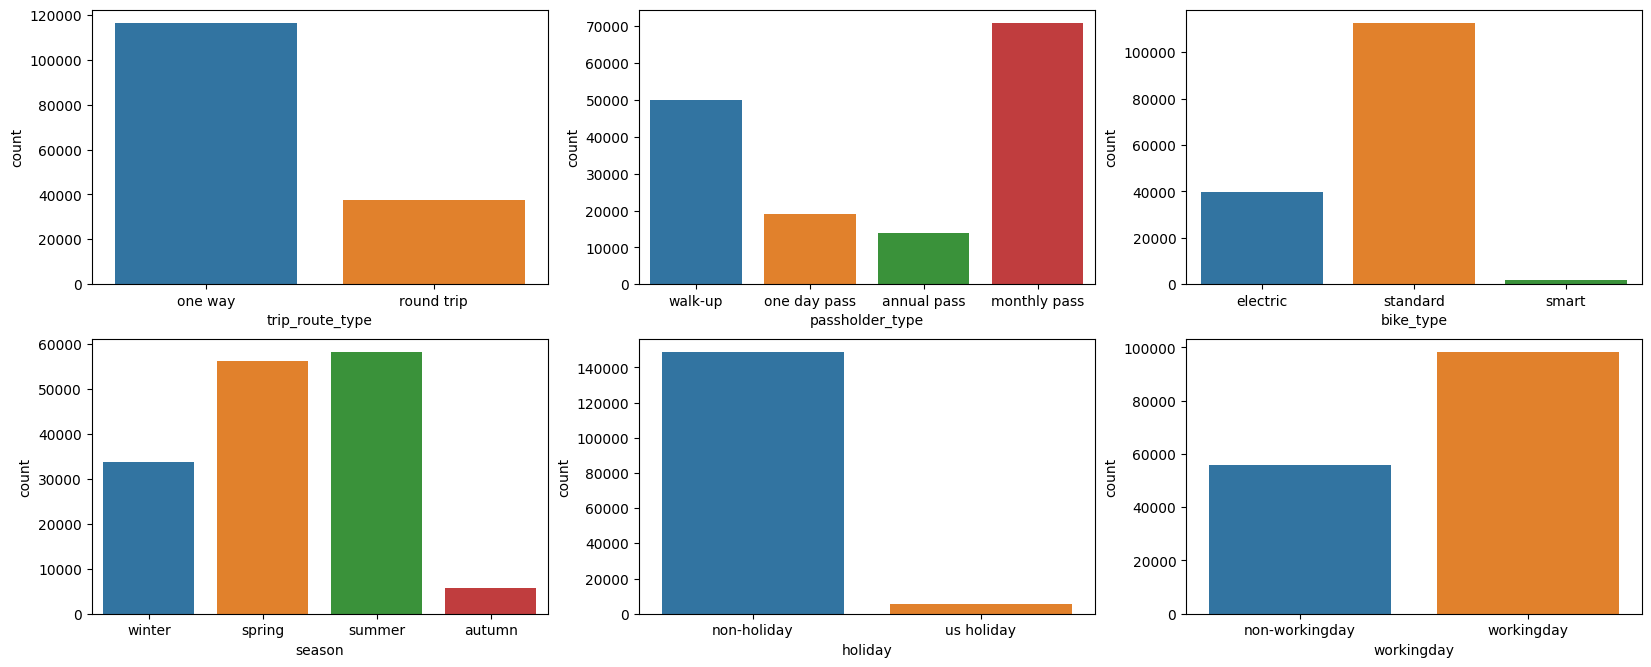

In [126]:
# countplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)

# col_name = ['trip_route_type', 'passholder_type', 'bike_type', 'season', 'holiday', 'workingday']

from copy import deepcopy
trip_data_dscrpt_df = deepcopy(trip_data_by_year_df)

trip_route_type = {1: 'one way', 2: 'round trip'}
trip_data_dscrpt_df['trip_route_type'] = [trip_route_type[x] for x in trip_data_by_year_df['trip_route_type']]
passholder_type = {1: 'walk-up', 2: 'one day pass', 3: 'monthly pass', 4: 'annual pass'}
trip_data_dscrpt_df['passholder_type'] = [passholder_type[x] for x in trip_data_by_year_df['passholder_type']]
bike_type = {1: 'standard', 2: 'electric', 3: 'smart'}
trip_data_dscrpt_df['bike_type'] = [bike_type[x] for x in trip_data_by_year_df['bike_type']]
season = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'autumn'}
trip_data_dscrpt_df['season'] = [season[x] for x in trip_data_by_year_df['season']]
holiday = {1: 'us holiday', 0: 'non-holiday'}
trip_data_dscrpt_df['holiday'] = [holiday[x] for x in trip_data_by_year_df['holiday']]
workingday = {1: 'workingday', 0: 'non-workingday'}
trip_data_dscrpt_df['workingday'] = [workingday[x] for x in trip_data_by_year_df['workingday']]

print(trip_data_dscrpt_df['passholder_type'].value_counts())

sns.countplot(trip_data_dscrpt_df['trip_route_type'], ax=axes[0][0])
sns.countplot(trip_data_dscrpt_df['passholder_type'], ax=axes[0][1])
sns.countplot(trip_data_dscrpt_df['bike_type'], ax=axes[0][2])
sns.countplot(trip_data_dscrpt_df['season'], ax=axes[1][0])
sns.countplot(trip_data_dscrpt_df['holiday'], ax=axes[1][1])
sns.countplot(trip_data_dscrpt_df['workingday'], ax=axes[1][2])

<AxesSubplot:xlabel='season', ylabel='ptd'>

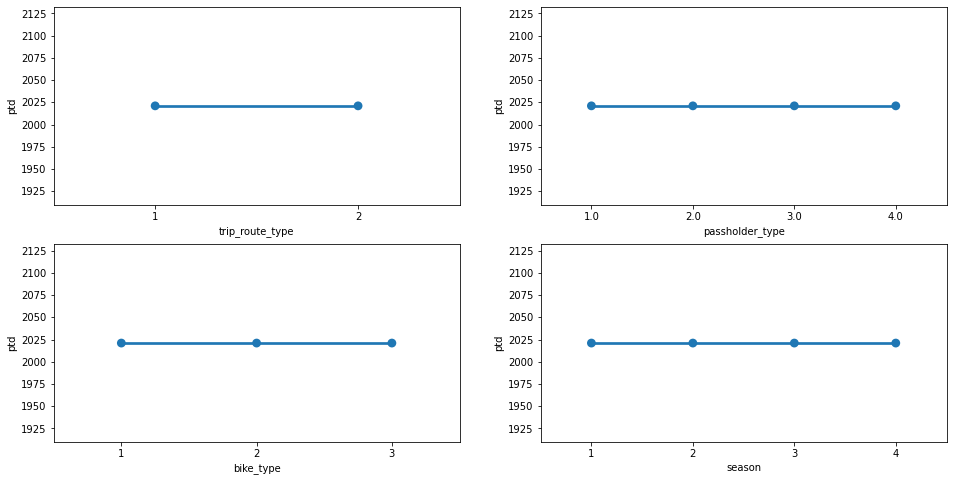

In [17]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 8)

sns.pointplot(data=trip_data_by_year_df, x='trip_route_type', y='ptd', ax=axes[0][0])
sns.pointplot(data=trip_data_by_year_df, x='passholder_type', y='ptd', ax=axes[0][1])
sns.pointplot(data=trip_data_by_year_df, x='bike_type', y='ptd', ax=axes[1][0])
sns.pointplot(data=trip_data_by_year_df, x='season', y='ptd', ax=axes[1][1])

# sns.pointplot(data=trip_data_by_year, x='trip_route_type', ax=axes[0][0])
# sns.pointplot(data=trip_data_by_year, x='passholder_type', ax=axes[0][1])
# sns.pointplot(data=trip_data_by_year, x='bike_type', ax=axes[0][2])
# sns.pointplot(data=trip_data_by_year, x='season', ax=axes[1][0])
# sns.pointplot(data=trip_data_by_year, x='holiday', ax=axes[1][1])
# sns.pointplot(data=trip_data_by_year, x='workingday', ax=axes[1][2])

## Modeling analysis by k-means

### Load Data 

In [111]:
# app_trip_cnt_by_hour
app_trip_cnt_by_hour_df = pd.read_csv('results/app/app_trip_cnt_by_hour/part-00000-a79cce04-7a63-4d9e-836b-2e225e7984f2-c000.csv')

In [112]:
app_trip_cnt_by_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   start_hour                        6046 non-null   object
 1   used_count                        6046 non-null   int64 
 2   total_duration                    6046 non-null   int64 
 3   plan_duration_day_count           6046 non-null   int64 
 4   plan_duration_month_count         6046 non-null   int64 
 5   plan_duration_year_count          6046 non-null   int64 
 6   trip_route_type_one_way_count     6046 non-null   int64 
 7   trip_route_type_round_trip_count  6046 non-null   int64 
 8   passholder_type_walk_up_count     6046 non-null   int64 
 9   passholder_type_one_day_count     6046 non-null   int64 
 10  passholder_type_monthly_count     6046 non-null   int64 
 11  passholder_type_annual_count      6046 non-null   int64 
 12  bike_type_standard_c

In [113]:
app_trip_cnt_by_hour_df.head(3)

,start_hour,used_count,total_duration,plan_duration_day_count,plan_duration_month_count,plan_duration_year_count,trip_route_type_one_way_count,trip_route_type_round_trip_count,passholder_type_walk_up_count,passholder_type_one_day_count,passholder_type_monthly_count,passholder_type_annual_count,bike_type_standard_count,bike_type_electric_count,bike_type_smart_count,season,holiday,workingday
0,2021-01-01 01:00:00,1,17,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0
1,2021-01-01 02:00:00,1,7,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0
2,2021-01-01 04:00:00,2,216,1,1,0,2,0,1,0,1,0,2,0,0,1,1,0


In [114]:
app_trip_cnt_by_hour_df.describe().T

,count,mean,std,min,25%,50%,75%,max
used_count,6046.0,25.469567,20.707366,1.0,6.00,22.0,40.0,142.0
total_duration,6046.0,1048.013397,1141.688522,1.0,160.25,684.0,1555.0,10524.0
plan_duration_day_count,6046.0,11.339563,11.908931,0.0,2.00,7.0,17.0,79.0
plan_duration_month_count,6046.0,11.736189,9.372877,0.0,3.00,11.0,18.0,112.0
plan_duration_year_count,6046.0,2.393649,2.627686,0.0,0.00,2.0,4.0,19.0
trip_route_type_one_way_count,6046.0,19.266788,15.579677,0.0,5.00,17.0,30.0,130.0
trip_route_type_round_trip_count,6046.0,6.202779,6.332285,0.0,1.00,4.0,10.0,48.0
passholder_type_walk_up_count,6046.0,8.279854,8.759412,0.0,1.00,5.0,12.0,60.0
passholder_type_one_day_count,6046.0,3.134138,4.248490,0.0,0.00,1.5,5.0,35.0
passholder_type_monthly_count,6046.0,11.735528,9.371976,0.0,3.00,11.0,18.0,112.0


<AxesSubplot:xlabel='holiday', ylabel='used_count'>

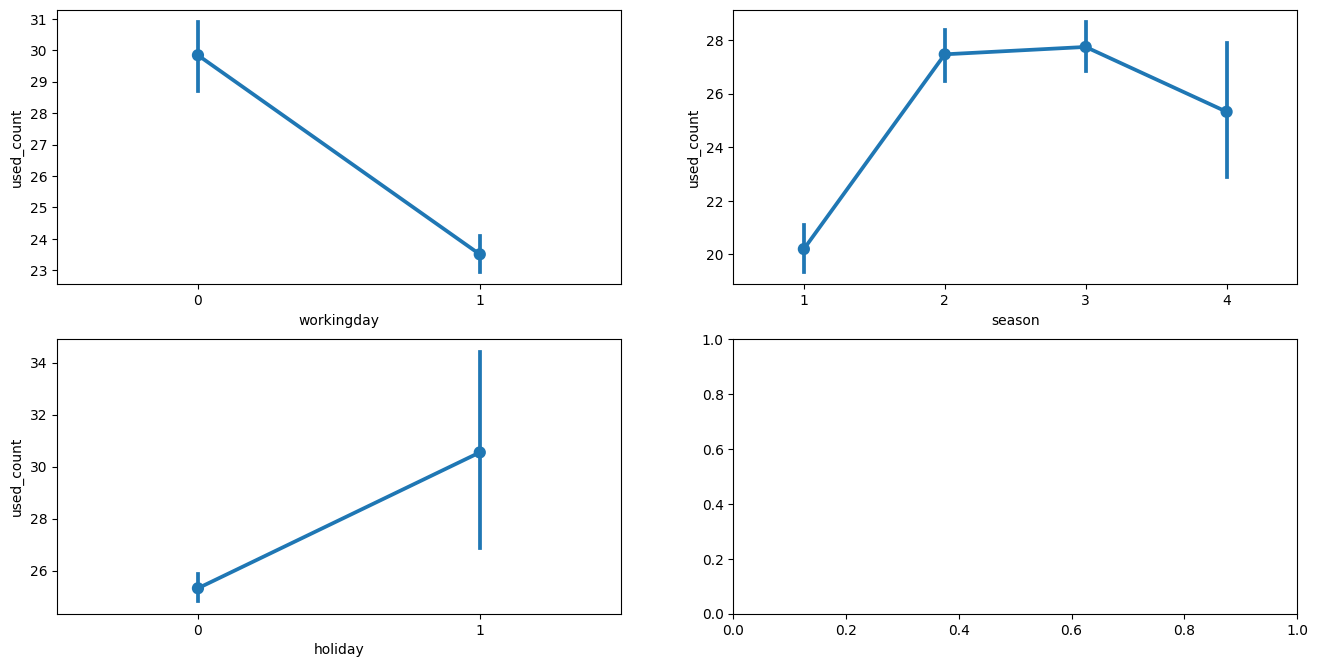

In [115]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.pointplot(data=app_trip_cnt_by_hour_df, x='workingday', y='used_count', ax=axes[0][0])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='season', y='used_count', ax=axes[0][1])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='holiday', y='used_count', ax=axes[1][0])

### Correlation matrix

<AxesSubplot:>

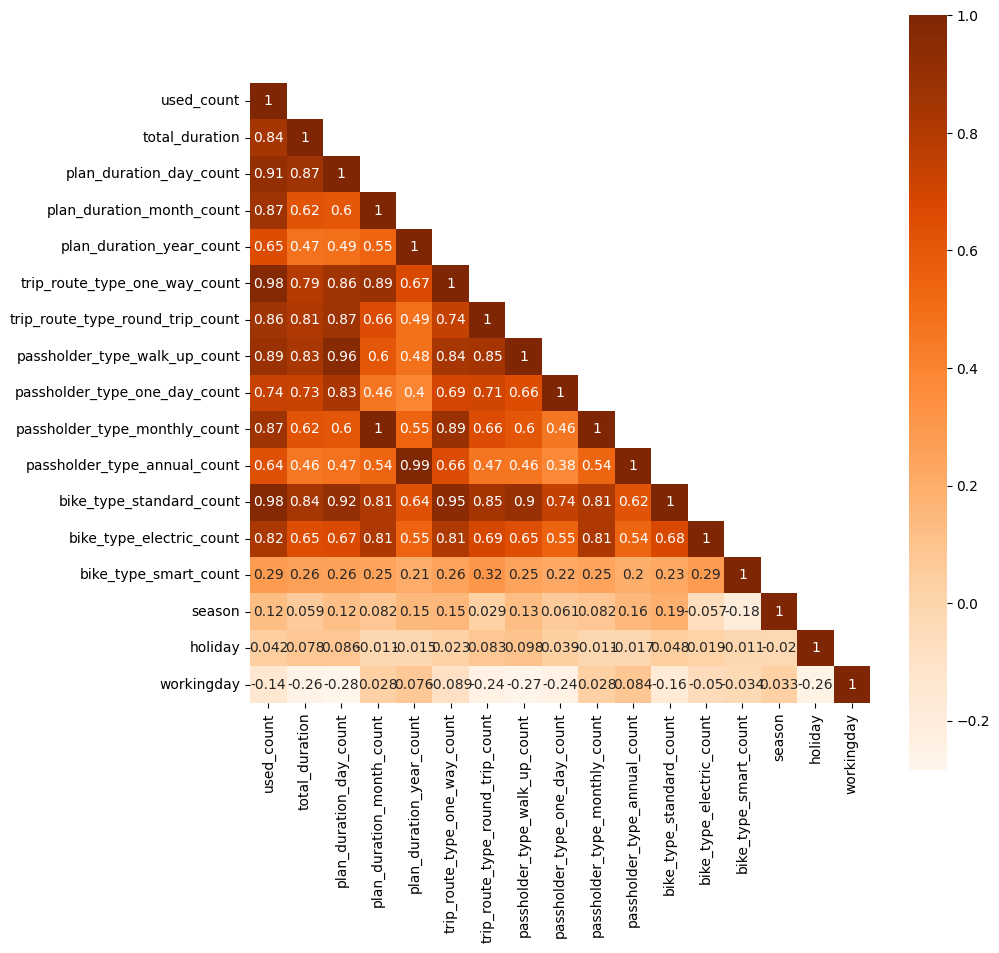

In [116]:
corr = app_trip_cnt_by_hour_df.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=corr,
            mask=mask,
            cmap='Oranges',
            square=True,
            annot=True,
            cbar=True)

In [15]:
# check missing value
trip_data_by_year_df.isna().sum()

trip_id            0
duration           0
start_station      0
start_lat          0
start_lon          0
end_station        0
end_lat            0
end_lon            0
bike_id            8
plan_duration      0
trip_route_type    0
passholder_type    1
bike_type          0
distance           0
distance_cal       0
used_date          0
used_hour          0
season             0
holiday            0
workingday         0
start_datetime     0
end_datetime       0
start_hour         0
ptd                0
dtype: int64

In [54]:
trip_data_by_year_df = trip_data_by_year_df.dropna(how='any')
trip_data_by_year_df.isnull().sum()

trip_id            0
duration           0
start_station      0
start_lat          0
start_lon          0
end_station        0
end_lat            0
end_lon            0
bike_id            0
plan_duration      0
trip_route_type    0
passholder_type    0
bike_type          0
distance           0
distance_cal       0
used_date          0
used_hour          0
season             0
holiday            0
workingday         0
start_datetime     0
end_datetime       0
start_hour         0
ptd                0
dtype: int64

In [16]:
from sklearn.cluster import KMeans
from sklearn import cluster
cluster.DBSCAN().get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

In [23]:
coordinate_data = trip_data_by_year_df.loc[:,['start_lon','start_lat']] # 取第’start_lon, start_lat’列的所有记录，df.loc[0, :]取第0行的所有记录

In [29]:
coordinate_data.head(3)

,start_lon,start_lat
0,-118.264549,34.077351
1,-118.288742,34.031502
2,-118.448280,33.958790


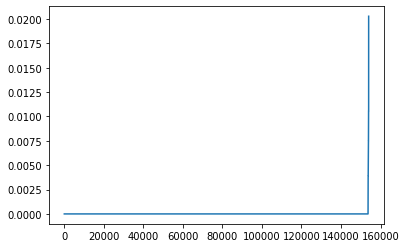

In [30]:
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

parking_min_bikes = 50
min_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=parking_min_bikes).fit(coordinate_data)  # 找到距离最近的50个点
distances, indices = nbrs.kneighbors(coordinate_data)  # 计算每个点最近的50个点的距离
dist = distances[:, (min_neighbors-1)]
dist_ = np.sort(dist)
plt.plot(dist_)

count:
8      28272
10     11845
9      11539
22      7828
11      6147
       ...  
88       102
66        74
105       67
85        59
90        57
Length: 112, dtype: int64
DBI=0.5711242286299573


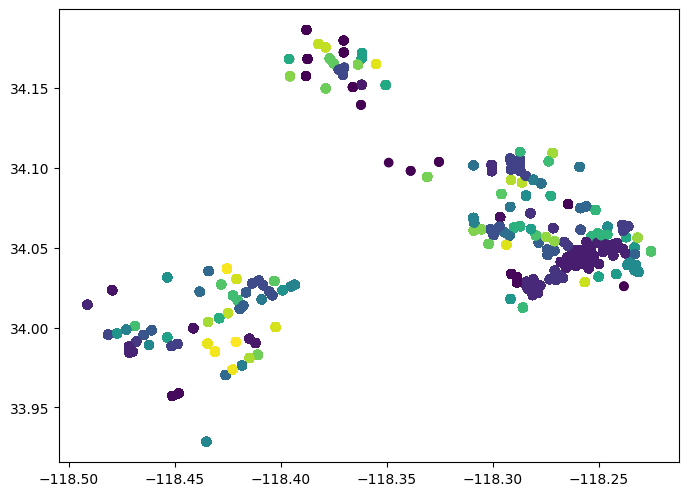

In [53]:
mdl_dbscan = cluster.DBSCAN(eps=0.004, min_samples=parking_min_bikes).fit(coordinate_data) # 聚类模型
# 模型预测的结果有多少个类，每个类有多少个样本
count = pd.Series(mdl_dbscan.labels_).value_counts()  # 展示有多少类，每类有多少个样本，即查看各个类别上的个数
print('count:')
print('{}'.format(count))

plt.figure()
plt.scatter(x='start_lon', y='start_lat', data=coordinate_data, c=mdl_dbscan.labels_)
# 聚类模型有两种评价模型，一种是组内距离越小越好，一种是组间距离越大越好 （组：类别）
DBI = metrics.davies_bouldin_score(coordinate_data, mdl_dbscan.labels_)
print('DBI={}'.format(DBI)) # 聚类模型评价指标

In [58]:
cluster_cnt = 3

from sklearn.cluster import KMeans
# 模型建立(预估器流程)
estimator = KMeans(n_clusters=cluster_cnt)
mdl_kmeans = estimator.fit(coordinate_data)
print(mdl_kmeans)

In [45]:
# 统计每个类的个数
count2 = pd.Series(mdl_kmeans.labels_).value_counts()
print(count2)

0    70632
1    64305
2    19052
dtype: int64


In [46]:
# 每个类中的坐标
km_centor = pd.DataFrame(mdl_kmeans.cluster_centers_, columns=['start_lon','start_lat'])
print(km_centor)

    start_lon  start_lat
0 -118.257872  34.046162
1 -118.454210  33.994614
2 -118.300176  34.088188


In [47]:
# 类中心
mdl_kmeans.cluster_centers_

array([[-118.25787229,   34.04616221],
       [-118.45421036,   33.99461444],
       [-118.30017626,   34.08818783]])

In [48]:
# 数量最多的十个类中心点
center_10=list(count2.index[:10])
center_10_cordinate=[]
for index in center_10:
    cordinate=mdl_kmeans.cluster_centers_[index]
    print(cordinate)
    center_10_cordinate.append(cordinate)

[-118.25787229   34.04616221]
[-118.45421036   33.99461444]
[-118.30017626   34.08818783]


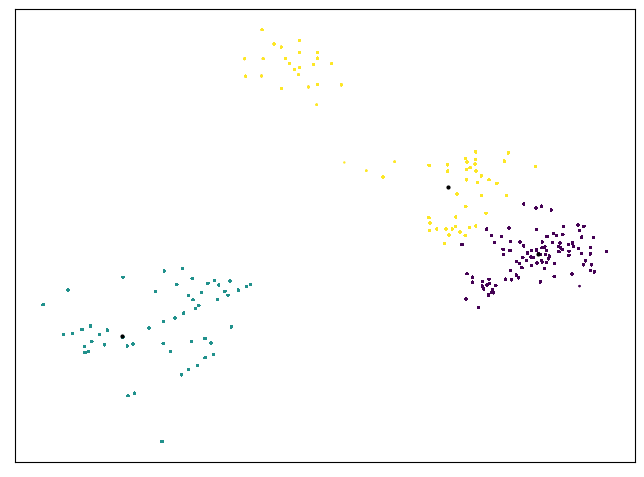

In [49]:
plt.rcParams['savefig.dpi'] = 300 # 像素
plt.rcParams['figure.dpi'] = 100 # 分辨率
plt.rcParams['figure.figsize']=(8.0, 6.0) # 图片大小比例
plt.figure()
plt.scatter(x='start_lon', y='start_lat', data=coordinate_data, c=mdl_kmeans.labels_, s=0.5) 
plt.scatter(x='start_lon', y='start_lat', data=km_centor, c='k', s=4)
plt.scatter(x='start_lon', y='start_lat', data=center_10_cordinate, c='r', marker='*', s=20)
# plt.savefig('mobike.png')

In [59]:
y_predict = estimator.predict(coordinate_data)

In [60]:
y_predict[:300]

array([2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1,
       2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1,
       2, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 1,
       1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1,
       2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], d

In [63]:
# 模型评估-轮廓系数
from sklearn.metrics import silhouette_score
ss = silhouette_score(coordinate_data, y_predict) # params: 特征，标记结果
print(ss)

0.6484679560485825
